# Create LDA model of Monster.com Jobs
- Richard Kuzma, 8SEP2020
- Pulled 22,000 Monster.com jobs in a csv from kaggle

#### Resources I used:
- <a href="https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28"> Using LDA Topic Models as a Classification Model Input </a> by Marc Kelechava. (<a href="https://github.com/marcmuon/nlp_yelp_review_unsupervised"> GitHub </a>)


## Imports

In [1]:
### Imports

# basic
import time
from pprint import pprint

# data science
import pandas as pd
import pickle

# NLP
import gensim
from gensim.models import CoherenceModel, LdaModel

# plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
### Import preprocesss_helpers module
import os
import sys

# add '/Users/richardkuzma/coding/analysis' to path
# where /utils holds module preprocess_helpers    
module_path = os.path.abspath(os.path.join('../..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.preprocess_helpers as ph

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Compute Perplexity
def compute_perplexity(corpus, model):
    """corpus is your bow corpus for instance"""
    """a measure of how good the model is. lower the better"""
    t0 = time.time()
    print('perplexing...')
    perplex = model.log_perplexity(corpus)
    print('{} seconds'.format(time.time()-t0))
    print('\nPerplexity: ', perplex)
    return perplex


def compute_coherence(model, texts, dictionary, coherence):
    """Takes model, texts, dictionary. Prints and outputs coherence score"""
    t0 = time.time()
    print('making coherence model...')
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
    print('{} seconds'.format(time.time()-t0))
    t0 = time.time()
    print('getting coherence...')
    coherence_lda = coherence_model_lda.get_coherence()
    print('{} seconds'.format(time.time()-t0))
    print('\nCoherence Score: ', coherence_lda)
    return coherence_lda

# Show graph
def coherence_graph(rg, coherence_values):
    plt.plot(rg, coherence_values, label = 'coherence')
#     plt.xlim(0, 22)
    plt.title("Coherence of LDA model")
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    print('plotted.')
    
def perplexity_graph(rg, perplex_values):
    plt.plot(rg, perplex_values, label = 'perplexity')
#     plt.xlim(0, 22)
    plt.title("Perplexity of LDA model")
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(("perplex_values"), loc='best')
    plt.show()
    print('plotted.')


# Print the coherence scores
def print_coherence_scores(rg, model_list, coherence_values):
    for num, cv, m in zip(rg, coherence_values, model_list):
        print("Num Topics = {} has Coherence Value of {} model specs: {}".format(num, round(cv, 4), m))


def visualize_lda(model, corpus, dictionary):
    """returns the pyLDAvis PreparedData given model, corpus, dictionary"""
    """Could pickle this to save it"""
    """pyLDAvis.save_html(vis, "filename") also works to export in html"""
    pyLDAvis.enable_notebook()
    t0 = time.time()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    print('{} seconds'.format(time.time()-t0))
    return vis


def compute_compare_c_v(dictionary, corpus, texts, rg=[2, 20, 6]):
    """
    Compute and compare c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplex_values = []
    model_list = []
    print('range entered: {}'.format(rg))
    for num_topics in rg:
        print('num_topics: {}'.format(num_topics))

        print('\nmaking model with {} topics...'.format(num_topics))

        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        print('model made: {}'.format(model))
        print('old model_list: {}'.format(model_list))
        model_list.append(model)
        print('appended. model_list now: {}'.format(model_list))

        print('\nperplexity...')
        p_score = compute_perplexity(corpus, model)
        perplex_values.append(p_score)
        print('appended perplexity')

        print('\ncoherence...')
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_score = compute_coherence(model, texts, dictionary, 'c_v') # my coherence model line
#         print('coherence: {}'.format(coherencemodel.get_coherence()))
#         coherence_values.append(coherencemodel.get_coherence())
        coherence_values.append(c_score)
        print('appended coherence')


    return model_list, coherence_values, perplex_values

## Load Monster jobs to df

In [10]:
path = '/Users/richardkuzma/coding/analysis/monster/data/cleaned/'
filename = 'monster_jobs_df_small.pkl'

with open(path+filename, 'rb') as f:
    df = pickle.load(f)


In [11]:
jobs_raw = df['job_description'].tolist()

## Process job_description text, make dictionary and BOW corpus

In [13]:
# clean text into lemmatized lists of unigrams, bigrams, trigrams
jobs_cleaned = ph.full_clean(jobs_raw)

# create dictionary
jobs_dict = ph.make_dict(jobs_cleaned)

# filter extremes from dict
jobs_dict.filter_extremes(no_below=20, no_above=0.5)
jobs_dict.compactify() # remove IDs for removed words

# make corpus
jobs_corpus = ph.make_bow(jobs_cleaned, jobs_dict)

lemmatizing...
lemmatization complete
941.2492010593414 seconds


## Save cleaned text, dictionary, corpus

In [15]:
path = '/Users/richardkuzma/coding/analysis/monster/data/cleaned/'

jobs_cleaned_filename = 'monster_jobs_cleaned_text.pkl'
with open(path+jobs_cleaned_filename, 'wb') as f:
    pickle.dump(jobs_cleaned, f)

jobs_dict_filename = 'monster_jobs_dict.pkl'
with open(path+jobs_dict_filename, 'wb') as f:
    pickle.dump(jobs_dict, f)
    
jobs_corpus_filename = 'monster_jobs_corpus.pkl'
with open(path+jobs_corpus_filename, 'wb') as f:
    pickle.dump(jobs_corpus, f)



## Choose best number of topics with HDP
HDP says 20...

In [16]:
from gensim.models import HdpModel
hdp = HdpModel(jobs_corpus, jobs_dict, chunksize=100)
len(hdp.print_topics())

## Choosing number of topics with perplexity / coherence

In [18]:
rg = list(range(10, 51, 5))
model_list, coherence_values, perplex_values = compute_compare_c_v(dictionary=jobs_dict, corpus=jobs_corpus, texts=jobs_cleaned,  rg=rg)

range entered: [10, 15, 20, 25, 30, 35, 40, 45, 50]
num_topics: 10

making model with 10 topics...
model made: LdaModel(num_terms=9441, num_topics=10, decay=0.5, chunksize=2000)
old model_list: []
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b205810>]

perplexity...
perplexing...
37.54220390319824 seconds

Perplexity:  -7.137424574309907
appended perplexity

coherence...
making coherence model...
0.003693819046020508 seconds
getting coherence...
105.36634373664856 seconds

Coherence Score:  0.4319444122998094
appended coherence
num_topics: 15

making model with 15 topics...
model made: LdaModel(num_terms=9441, num_topics=15, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b205810>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b205810>, <gensim.models.ldamodel.LdaModel object at 0x7fba2b33b510>]

perplexity...
perplexing...
40.47723913192749 seconds

Perplexity:  -7.262435814523

58.941691875457764 seconds

Perplexity:  -7.6298817555321055
appended perplexity

coherence...
making coherence model...
0.010699987411499023 seconds
getting coherence...
324.10479402542114 seconds

Coherence Score:  0.47191866213735323
appended coherence


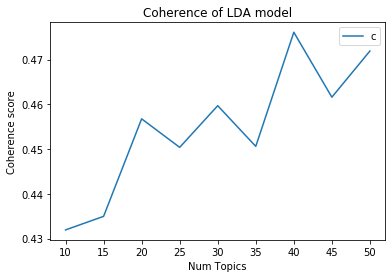

plotted.


In [19]:
coherence_graph(rg, coherence_values)

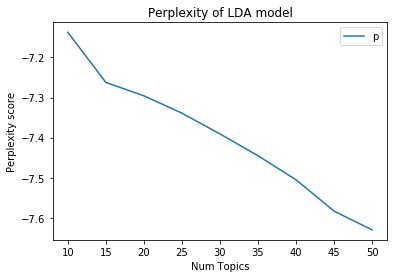

plotted.


In [20]:
perplexity_graph(rg, perplex_values)

In [21]:
rg2 = list(range(60, 101, 10))
model_list2, coherence_values2, perplex_values2 = compute_compare_c_v(dictionary=jobs_dict, corpus=jobs_corpus, texts=jobs_cleaned,  rg=rg2)



range entered: [60, 70, 80, 90, 100]
num_topics: 60

making model with 60 topics...
model made: LdaModel(num_terms=9441, num_topics=60, decay=0.5, chunksize=2000)
old model_list: []
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b2f8fd0>]

perplexity...
perplexing...
61.85459613800049 seconds

Perplexity:  -7.773173047890227
appended perplexity

coherence...
making coherence model...
0.01002192497253418 seconds
getting coherence...
400.07529520988464 seconds

Coherence Score:  0.4514407729412135
appended coherence
num_topics: 70

making model with 70 topics...
model made: LdaModel(num_terms=9441, num_topics=70, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b2f8fd0>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b2f8fd0>, <gensim.models.ldamodel.LdaModel object at 0x7fba2b34c590>]

perplexity...
perplexing...
71.80747985839844 seconds

Perplexity:  -7.9204269462569075
appended pe

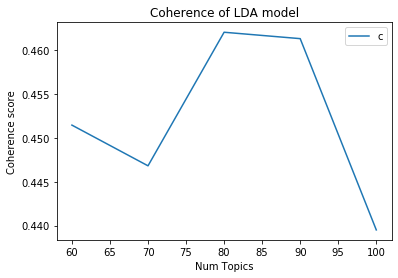

plotted.


In [22]:
coherence_graph(rg2, coherence_values2)

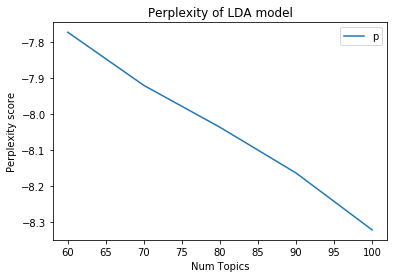

plotted.


In [23]:
perplexity_graph(rg2, perplex_values2)

In [24]:
rg3 = list(range(2, 10, 2))
model_list3, coherence_values3, perplex_values3 = compute_compare_c_v(dictionary=jobs_dict, corpus=jobs_corpus, texts=jobs_cleaned,  rg=rg3)



range entered: [2, 4, 6, 8]
num_topics: 2

making model with 2 topics...
model made: LdaModel(num_terms=9441, num_topics=2, decay=0.5, chunksize=2000)
old model_list: []
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b39b050>]

perplexity...
perplexing...
34.28424382209778 seconds

Perplexity:  -7.353080298860728
appended perplexity

coherence...
making coherence model...
0.0011889934539794922 seconds
getting coherence...
39.36594200134277 seconds

Coherence Score:  0.31991440618975026
appended coherence
num_topics: 4

making model with 4 topics...
model made: LdaModel(num_terms=9441, num_topics=4, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b39b050>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7fba2b39b050>, <gensim.models.ldamodel.LdaModel object at 0x7fba2b68cd50>]

perplexity...
perplexing...
35.70252704620361 seconds

Perplexity:  -7.2500859851675585
appended perplexity

coh

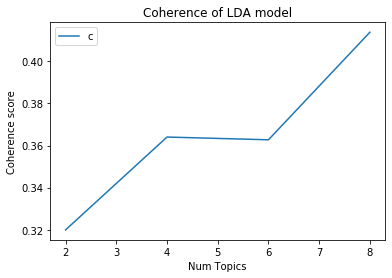

plotted.


In [25]:
coherence_graph(rg3, coherence_values3)

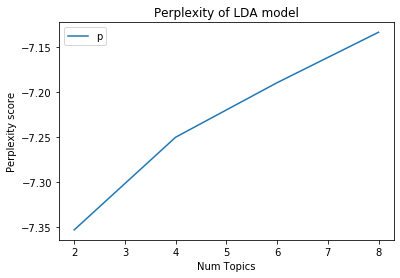

plotted.


In [26]:
perplexity_graph(rg3, perplex_values3)

### Merge models, coherence, perplexity lists

In [73]:
all_models_list = model_list3 + model_list + model_list2
all_coherence_values = coherence_values3 + coherence_values + coherence_values2
all_perplex_values =  perplex_values3 + perplex_values + perplex_values2
all_rg = rg3 + rg + rg2

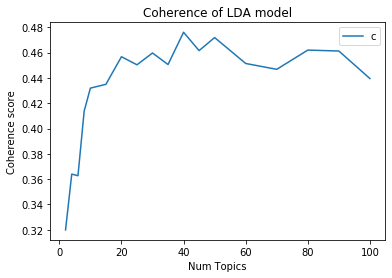

plotted.


In [83]:
coherence_graph(all_rg, all_coherence_values)

In [85]:
path = '/Users/richardkuzma/coding/analysis/monster/plots/'
plt.savefig(path+'monster_jobs_coherence.png')

<Figure size 432x288 with 0 Axes>

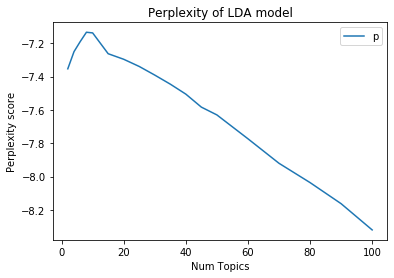

plotted.


In [86]:
perplexity_graph(all_rg, all_perplex_values)

In [87]:
path = '/Users/richardkuzma/coding/analysis/monster/plots/'
plt.savefig(path+'monster_jobs_LDA_perplexity.png')

<Figure size 432x288 with 0 Axes>

In [79]:
pprint(all_coherence_values)

[0.31991440618975026,
 0.3640274743203482,
 0.36272370915465696,
 0.4138067991472481,
 0.4319444122998094,
 0.43497476729058804,
 0.45676427861674707,
 0.4503930881732514,
 0.4596995536571995,
 0.45061473053082324,
 0.4761139930886699,
 0.4616020782029181,
 0.47191866213735323,
 0.4514407729412135,
 0.4468074900432019,
 0.4620123886171289,
 0.4612845277602373,
 0.4395108417858205]


### Pick best models (coherence)
- 40 topics has coherence of 0.4761
- 50 topics has coherence of 0.4719
- 90 topics has coherence of 0.4613  <em>(maybe better to have 2x more topics with only minimal drop in coherence?)</em>

Will save both the 40 topics and 90 topic versions

In [78]:
# pick the best
print('Best coherence model')
best_coherence_value = max(all_coherence_values, key=abs)
best_coherence_index = all_coherence_values.index(best_coherence_value)
best_coherence_model = all_models_list[best_coherence_index]
best_coherence_num_topics = best_coherence_model.num_topics

print(best_coherence_value)
print(best_coherence_index)
print(best_coherence_model)
print(best_coherence_num_topics)

Best coherence model
0.4761139930886699
10
LdaModel(num_terms=9441, num_topics=40, decay=0.5, chunksize=2000)
40


In [97]:
print('90 topic coherence model')
ninety_idx = 0
for i in all_models_list:
    if i.num_topics == 90:
        print('index of 90 found: {}'.format(ninety_idx))
        break
    ninety_idx += 1


ninety_coherence_value = all_coherence_values[ninety_idx]
ninety_coherence_model = all_models_list[ninety_idx]
ninety_num_topics = ninety_coherence_model.num_topics

print('idx: {}'.format(ninety_idx))
print('cv: {}'.format(ninety_coherence_value))
print('model: {}'.format(ninety_coherence_model))
print('num_topics: {}'.format(ninety_num_topics))

90 topic coherence model
index of 90 found: 16
idx: 16
cv: 0.4612845277602373
model: LdaModel(num_terms=9441, num_topics=90, decay=0.5, chunksize=2000)
num_topics: 90


In [98]:
### save 40 and 90 topic models
path = '/Users/richardkuzma/coding/analysis/monster/models/'

filename = 'monster_jobs_LDA_40_topics_cv_zero476.pkl'
with open(path+filename, 'wb') as f:
    pickle.dump(best_coherence_model, f)
    
filename = 'monster_jobs_LDA_90_topics_cv_zero461.pkl'
with open(path+filename, 'wb') as f:
    pickle.dump(ninety_coherence_model, f)

### Pick best models (perplexity)
- 

In [88]:
pprint(all_perplex_values)

[-7.353080298860728,
 -7.2500859851675585,
 -7.189505216938566,
 -7.133448350948939,
 -7.137424574309907,
 -7.262435814523401,
 -7.29577336655376,
 -7.338961625838196,
 -7.390738103953693,
 -7.445171118704983,
 -7.50504603056342,
 -7.583116248143664,
 -7.6298817555321055,
 -7.773173047890227,
 -7.9204269462569075,
 -8.036359320350192,
 -8.163078887280552,
 -8.320657360555696]


In [101]:
# pick the best
print('Best perplexity model')
best_perplexity_value = min(all_perplex_values, key=abs)
best_perplexity_index = all_perplex_values.index(best_perplexity_value)
best_perplexity_model = all_models_list[best_perplexity_index]
best_perplexity_num_topics = best_perplexity_model.num_topics

print('idx: {}'.format(best_perplexity_index))
print('perplexity: {}'.format(best_perplexity_value))
print('model: {}'.format(best_perplexity_model))
print('num_topics: {}'.format(best_perplexity_num_topics))


Best perplexity model
idx: 3
perplexity: -7.133448350948939
model: LdaModel(num_terms=9441, num_topics=8, decay=0.5, chunksize=2000)
num_topics: 8


In [102]:
### save best perplexity model (8 topics)
path = '/Users/richardkuzma/coding/analysis/monster/models/'

filename = 'monster_jobs_LDA_8_topics_best_perplexity.pkl'
with open(path+filename, 'wb') as f:
    pickle.dump(best_perplexity_model, f)